In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn import linear_model
%matplotlib inline

# Question 1: Propensity score matching

In [14]:
file_name = "lalonde.csv"
lalonde_data = pd.read_csv(file_name)
lalonde_data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### Dataset description

- **treat:** 1 if the subject participated in the job training program, 0 otherwise
- **age:** the subject's age
- **educ:** years of education
- **race:** categorical variable with three possible values: Black, Hispanic, or White
- **married:** 1 if the subject was married at the time of the training program, 0 otherwise
- **nodegree:** 1 if the subject has earned no school degree, 0 otherwise
- **re74:** real earnings in 1974 (pre-treatment)
- **re75:** real earnings in 1975 (pre-treatment)
- **re78:** real earnings in 1978 (outcome)

In [30]:
subject_Control = lalonde_data[lalonde_data.treat==0]
subject_Treated = lalonde_data[lalonde_data.treat==1]
lalonde_data.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


## 1. A naive analysis

First, let see the real earnings distribution in 1978 for the control and treated group in a boxplot.

Group proportion
Control:  0.6986970684039088
Treated:  0.30130293159609123


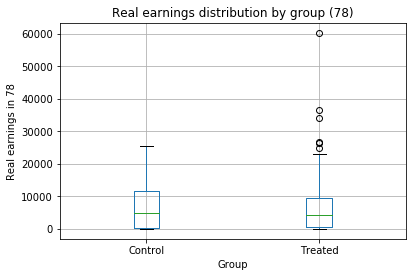

In [31]:
# Make the boxplot
lalonde_data.boxplot('re78', by='treat')
plt.xticks([1, 2], ['Control', 'Treated'])
plt.xlabel("Group")
plt.ylabel("Real earnings in 78")
plt.title("Real earnings distribution by group (78)")
plt.suptitle("")

# Group proportion
print("Group proportion")
print("Control: ",len(subject_Control)/len(lalonde_data))
print("Treated: ",len(subject_Treated)/len(lalonde_data))

We see that in both group, the first quartile value is 0. Let take a closer look:

In [32]:
print("Percentage of subject with null earnings in 78")

#Control Group
nullControl_re78 = len(subject_Control.re78[subject_Control.re78 == 0])
nullControlPercentage_re78 = nullControl_re78*100/len(subject_Control)
print("Control subject: ",nullControlPercentage_re78)

#Treated Group
nullTreated_re78 = len(subject_Treated.re78[subject_Treated.re78 == 0])
nullTreatedPercentage_re78 = nullTreated_re78*100/len(subject_Treated)
print("Treated subject: ",nullTreatedPercentage_re78)

Percentage of subject with null earnings in 78
Control subject:  22.843822843822842
Treated subject:  24.324324324324323


**Observation:**

The distributions for both group are very similar, only few treated subjects have a big relative earnings. We can affirm that the treatment have a significant effect.
Even the proportion of subject with zero earnings is quite the same.

## 2. A closer look at the data

### Distribution of each continuous feature grouped by treatment group

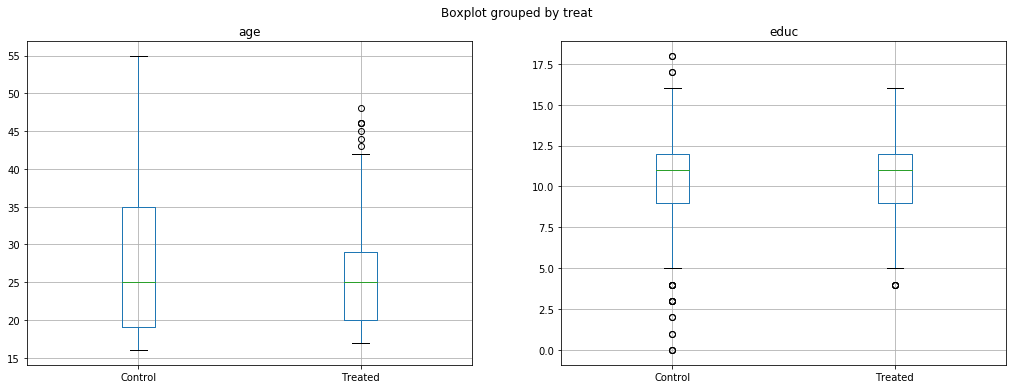

In [33]:
#continuous parameters
params = ["age", "educ"]

#boxplot
fig, axS = plt.subplots(1, 2, figsize=(17,6))
for ax, param in zip(axS.flatten(), params):
    lalonde_data.boxplot(column=param, by='treat', ax=ax)
    ax.set_xticklabels(['Control', 'Treated'])
    ax.set_xlabel('')
    

### Distribution of each discrete feature grouped by treatment group

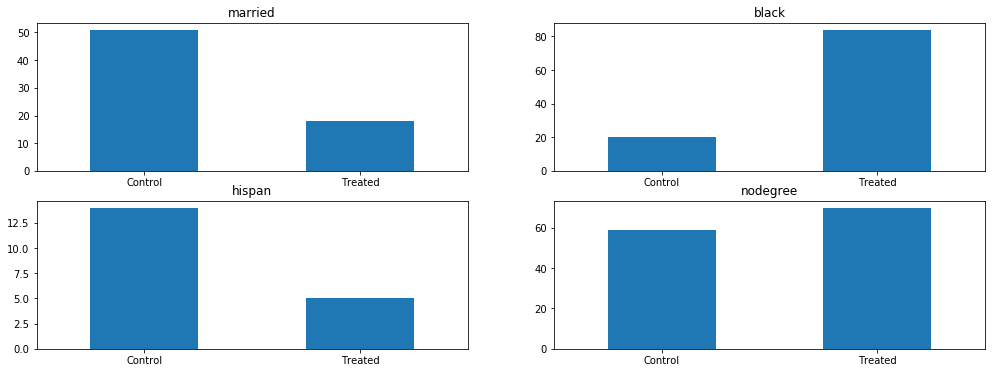

In [34]:
#discrete parameters
params = ["married", "black", "hispan", "nodegree"]

#boxplot
fig, axS = plt.subplots(2, 2, figsize=(17,6))
for ax, param in zip(axS.flatten(), params):
    group = lalonde_data[[param, 'treat']].groupby('treat').sum()
    group[param][0] = 100*group[param][0]/len(subject_Control)
    group[param][1] = 100*group[param][1]/len(subject_Treated)
    group.plot(kind='bar', ax=ax, legend=False, title=param)
    ax.set_xticklabels(['Control', 'Treated'], rotation=0)
    ax.set_xlabel('')

### Distribution of real earnings grouped by treatment group

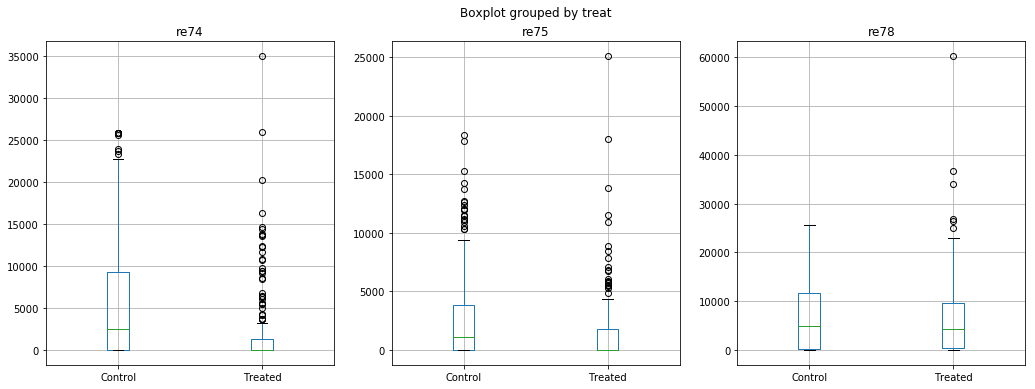

In [35]:
#continuous parameters
params = ["re74", "re75", "re78"]

#boxplot
fig, axS = plt.subplots(1, 3, figsize=(17,6))
for ax, param in zip(axS.flatten(), params):
    lalonde_data.boxplot(column=param, by='treat', ax=ax)
    ax.set_xticklabels(['Control', 'Treated'])
    ax.set_xlabel('')
    

At first sight (naive analysis) we could say that the treatment doesn't help. But with the time perspective, we observe that the real earnings of treated subject tend to increase.

## 3. A propensity score model

In [75]:
logistic = linear_model.LogisticRegression()
X = lalonde_data.iloc[:,2:10]
Y = lalonde_data.treat
logistic = logistic.fit(X.as_matrix(),np.int64(Y.as_matrix()))

lalonde_data['Propensity_score'] = logistic.predict_proba(X)[:,1]
lalonde_data.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,Propensity_score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


Let's diplay the propensy score for the person who receive the treatment and whose who don't to determine how precise we are.

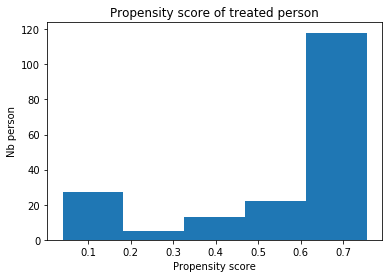

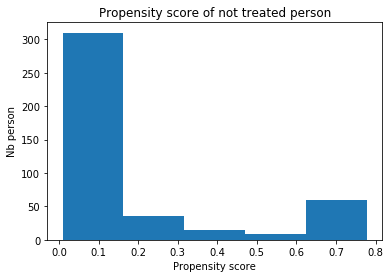

In [76]:
lalonde_treated = lalonde_data.loc[lalonde_data["treat"]==1]
lalonde_not_treated = lalonde_data.loc[lalonde_data["treat"]==0]

plt.hist(lalonde_treated['Propensity_score'],bins=5)
plt.title('Propensity score of treated person')
plt.xlabel('Propensity score')
plt.ylabel('Nb person')
plt.show()
plt.hist(lalonde_not_treated['Propensity_score'],bins=5)
plt.title('Propensity score of not treated person')
plt.xlabel('Propensity score')
plt.ylabel('Nb person')
plt.show()

As we can see the propensy score is much bigger for the treated person.

## 4. Balancing the dataset via matching

To build our graph we deciced to choose the following cost function which will be the weight of the edge between two nodes.
\begin{align}
\mathbf W_{i,j}= |{ps_i - ps_j}|
\end{align}

In [92]:
lalonde_weights = pd.DataFrame(columns=['Treated','Control','weight'])

for treated in lalonde_treated[['id','Propensity_score']].iterrows():
    for test in lalonde_not_treated[['id','Propensity_score']].iterrows():
        cost = np.abs(treated[1]['Propensity_score'] - test[1]['Propensity_score'])
        lalonde_weights.loc[len(lalonde_weights)] = [treated[1]['id'],test[1]['id'], 1 - cost]
        
lalonde_weights.tail()

,Treated,Control,weight
79360,NSW185,PSID425,0.601472
79361,NSW185,PSID426,0.573285
79362,NSW185,PSID427,0.587706
79363,NSW185,PSID428,0.984963
79364,NSW185,PSID429,0.619606


Now we gonna build the graph and extract the best pair of nodes for each treated subjects.

In [93]:
G = nx.from_pandas_dataframe(lalonde_weights, 'Treated', 'Control', 'weight')
best_matches = nx.max_weight_matching(G, maxcardinality=True)

#We store the bestmatches in a panda df.
lalonde_matches = pd.DataFrame(columns=['Treated','Control'])
for (key,value) in best_matches.items():
    if "NSW" in key:
        lalonde_matches.loc[len(lalonde_matches)] = [key,value]
lalonde_matches = lalonde_matches.sort_values(by="Treated")
lalonde_matches.head()

,Treated,Control
98,NSW1,PSID200
28,NSW10,PSID40
19,NSW100,PSID274
156,NSW101,PSID211
153,NSW102,PSID247
139,NSW103,PSID213
1,NSW104,PSID374
0,NSW105,PSID388
144,NSW106,PSID369
96,NSW107,PSID173


Now that we got the best matches we gonna their respective re78 to compare them.

In [94]:
#To save us some time we decided to set the index of the df as the previous Id column to save us some time
lalonde_indexed = lalonde_data.set_index('id')

#We add the re78 of the treated and test sample for each match.
lalonde_matches['re78_Treated']  = list(lalonde_indexed.loc[lalonde_matches['Treated']]['re78'])
lalonde_matches['re78_Control']  = list(lalonde_indexed.loc[lalonde_matches['Control']]['re78'])
lalonde_matches.head()

,Treated,Control,re78_Treated,re78_Control
98,NSW1,PSID200,9930.046,0.0000
28,NSW10,PSID40,12418.070,12104.0600
19,NSW100,PSID274,26817.600,7503.8960
156,NSW101,PSID211,0.000,15554.5500
153,NSW102,PSID247,9265.788,642.8111


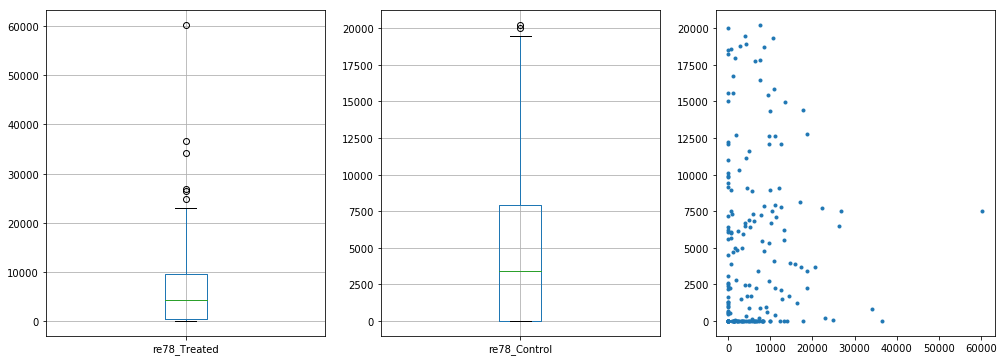

In [103]:
#boxplot
#continuous parameters
params = ["re78_Treated", "re78_Control"]
fig, axS = plt.subplots(1, 3, figsize=(17,6))
for ax, param in zip(axS.flatten(), params):
    lalonde_matches.boxplot(column=param, ax=ax)
    
    
plt.plot(lalonde_matches['re78_Treated'],lalonde_matches['re78_Control'],'.')

plt.show()

# Question 2:

In [40]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Q2.1

* Loading dataset 

In [41]:
newsgroups = fetch_20newsgroups()

* newsgroups.description : 'the 20 newsgroups by date dataset'
* newsgroups.filenames : 
    * ../20news_home/20news-bydate-train/rec.autos/102994',
    * ../20news_home/20news-bydate-train/comp.sys.mac.hardware/51861'
    * ..

In [42]:
newsgroups.data[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

* We are using TF_IDF. (for more details https://fr.wikipedia.org/wiki/TF-IDF )

In [43]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups.data)
vectors.shape
#len(vectorizer.vocabulary_)

(11314, 130107)

* 11314: total number of documents (filename)
* 130107: total number of unique word

In [44]:
# We see that this matrix is very sparse
vectors.nnz / float(vectors.shape[0])

157.9958458546933

In [45]:
first_news = vectors.toarray()[0]
first_news[np.nonzero(first_news)]

array([ 0.06332604,  0.14155753,  0.13874908,  0.0953487 ,  0.03709893,
        0.10278592,  0.02991186,  0.0871642 ,  0.16713176,  0.09353931,
        0.13280753,  0.03770449,  0.0690878 ,  0.0343176 ,  0.38133891,
        0.07801368,  0.04951999,  0.06621689,  0.10015015,  0.11603643,
        0.0845253 ,  0.05461429,  0.09714744,  0.13412921,  0.05747015,
        0.08646963,  0.1558717 ,  0.02921528,  0.08342748,  0.03542092,
        0.06363421,  0.09785516,  0.02245166,  0.07313444,  0.07325812,
        0.05097865,  0.04280825,  0.09219024,  0.35383501,  0.01921946,
        0.09036441,  0.0690878 ,  0.06339409,  0.05989857,  0.10936401,
        0.03955173,  0.08844382,  0.03696979,  0.07000411,  0.13157119,
        0.03567186,  0.06521174,  0.05715821,  0.03188937,  0.01992886,
        0.0454964 ,  0.04114286,  0.09913274,  0.05545703,  0.03447138,
        0.10826904,  0.16068606,  0.05666562,  0.08171219,  0.0846283 ,
        0.09869735,  0.07526016,  0.10844725,  0.10809248,  0.01

In [46]:
y = newsgroups.target
X = vectors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1)

* Tried to compare for the first news, words with the 10 highest tf-idf score and the news label

In [47]:
print("the 10 words with the highest tf-idf score: ")
for ind in np.argsort(X_train.toarray()[0])[-10:]:
    print(list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(ind)])
# True Label
print("The true label is: %s"%(newsgroups.target_names[y_train[0]]))

the 10 words with the highest tf-idf score: 
shinobi
3719
iud
thunderforce
stanford
alexander
games
genesis
sega
hinds
The true label is: misc.forsale


# Q2.2

* First we train a blind randomForest model¶

In [48]:
clf = RandomForestClassifier(random_state=20) 
clf.fit(X_train, y_train) 
print("Accuracy : %f"%(clf.score(X_test,y_test)))

Accuracy : 0.636926


* Set the parameters by cross-validation

In [51]:
tuned_parameters = {'max_depth': [2,3,4,5], 'n_estimators': [100,500,900,1000,1200,1300,1400]} 
clf = RandomForestClassifier(random_state=20) 
clf = GridSearchCV(clf, tuned_parameters, cv=5) 
clf.fit(X_validation, y_validation)

Best parameters set found on development set:


AttributeError: 'GridSearchCV' object has no attribute 'bestparams'

In [57]:
print("Best parameters set found on development set:") 
print(clf.best_params_) 
print("Grid scores on development set:") 
means = clf.cv_results_['mean_test_score'] 
stds = clf.cv_results_['std_test_score'] 
for mean, std, params in zip(means, stds, clf.cv_results_['params']): 
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

Best parameters set found on development set:
{'max_depth': 5, 'n_estimators': 1400}
Grid scores on development set:
0.294 (+/-0.037) for {'max_depth': 2, 'n_estimators': 100}
0.295 (+/-0.020) for {'max_depth': 2, 'n_estimators': 500}
0.299 (+/-0.025) for {'max_depth': 2, 'n_estimators': 900}
0.295 (+/-0.024) for {'max_depth': 2, 'n_estimators': 1000}
0.299 (+/-0.042) for {'max_depth': 2, 'n_estimators': 1200}
0.296 (+/-0.048) for {'max_depth': 2, 'n_estimators': 1300}
0.295 (+/-0.037) for {'max_depth': 2, 'n_estimators': 1400}
0.363 (+/-0.053) for {'max_depth': 3, 'n_estimators': 100}
0.382 (+/-0.033) for {'max_depth': 3, 'n_estimators': 500}
0.380 (+/-0.030) for {'max_depth': 3, 'n_estimators': 900}
0.385 (+/-0.033) for {'max_depth': 3, 'n_estimators': 1000}
0.380 (+/-0.040) for {'max_depth': 3, 'n_estimators': 1200}
0.388 (+/-0.045) for {'max_depth': 3, 'n_estimators': 1300}
0.388 (+/-0.048) for {'max_depth': 3, 'n_estimators': 1400}
0.433 (+/-0.081) for {'max_depth': 4, 'n_estimato

* Selected model

In [59]:
MAX_DEPTH = clf.best_params_['max_depth'] 
N_ESTM = clf.best_params_['n_estimators']

clf = RandomForestClassifier(max_depth=MAX_DEPTH,n_estimators=N_ESTM,random_state=20) 
clf.fit(X_train, y_train)
clf.score(X_test,y_test)
print("View the prediction for the 10 doc") 
print("true label: %f , predicted label: %f "% (y_test[10],clf.predict(X_test[10])))

View the prediction for the 10 doc
true label: 3.000000 , predicted label: 3.000000 


* By definition a confusion matrix C is such that C_{i, j} is equal to the number of observations known to be in group i but predicted to be in group j.

In [60]:
confusion_matrix(y_test,clf.predict(X_test))

array([[23,  0,  0,  0,  0,  0,  4,  0,  0,  0,  0,  0,  3,  0,  1, 18,  0,
         2,  0,  0],
       [ 0, 39,  4,  2,  4,  2, 15,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  0],
       [ 0,  0, 36,  6,  1,  2,  9,  1,  0,  0,  0,  0,  1,  0,  1,  1,  0,
         0,  0,  0],
       [ 0,  0,  6, 33,  1,  0, 17,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  0],
       [ 0,  0,  0,  2, 37,  0,  6,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  0],
       [ 0,  2,  1,  0,  0, 50, 10,  0,  0,  0,  0,  1,  0,  1,  2,  0,  0,
         0,  0,  0],
       [ 0,  0,  2,  0,  0,  0, 43,  0,  0,  1,  0,  0,  1,  0,  1,  0,  0,
         0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  7, 39,  1,  0,  0,  0,  2,  0,  1,  1,  1,
         0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  5,  2, 53,  0,  0,  1,  1,  0,  1,  0,  0,
         0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  5,  0,  0, 53,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0],
       [ 0,  0,  0,  0,  0,  0

In [62]:
print(clf.feature_importances_)

[ 0.00011073  0.00010693  0.         ...,  0.          0.          0.        ]


The feature importances show us the most important keyword that influence the classification. 

In [68]:
#top 20 most important words
for ind in np.argsort(clf.feature_importances_)[-20:]:
    print(list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(ind)])

god
key
escrow
nhl
rutgers
crypto
bikes
baseball
athos
israel
bike
car
encryption
israeli
hockey
gun
sale
space
clipper
dod
